# UAV Dataset Pre-processing Example

The dataset consists of real-time recorded videos of a UAV flying close-to-ground. Although the specific height is not specified, the UAV operates at a height that clearly captures moving objects and people. There are two copies of the dataset with frames at 32 and 10 fps. The example below is shown using the 10 fps due to lower memory consumption from uploading to git. Lastly, the videos are categorized by itemized instances of particular scenes (eg. boat1, boat2, boat3 etc.).


The dataset will be used to train a gan to generate videos given a particular image by predicting future frames. I implemented the modeling and training using Pytorch. Below is a summary of the data pre-processing steps before training and testing which will be further explained in details:

    1. Save image paths in a structured pickle file as pandas dataframe
    2. Create custom Dataset class
    3. Use Dataset class to construct Dataloader
    4. Apply transforms: resize (due to compute constraints), to tensor, normalization
    

In [63]:
# Import packages
import imageio
from PIL import Image
from imageio import imread
from torchvision import transforms, utils
import os
import pickle
import numpy as np
from keras.preprocessing import image
from skimage import io, transform
import torch
import pandas as pd
import os
import pandas as pd
import pickle
from torch.utils.data import DataLoader
from skimage import img_as_ubyte



# Saving image paths

The structure of the dataset is exposed in this methods. 

In [25]:
# %load core/save_data_pickle.py

def save_data_csv(prefix, root_dir, file_to_save):
    data_frame = []
    
    # concatenate into a list
    if not isinstance(prefix, list):
        prefix = [prefix]
        
    # iterate through subdirectories
    for sub_dir in os.listdir(root_dir):
        # check if any selected prefixes are in directory str
        if any(pre in sub_dir for pre in prefix):
            class_dir = os.path.join(root_dir, sub_dir)
            img_names = os.listdir(class_dir)
            # append each path
            for images in img_names:
                data_frame.append([os.path.join(class_dir, images), sub_dir])
    
    # sort in order
    data_frame.sort(key = lambda x: x[0]) 
    pd_data_frame = pd.DataFrame(data_frame, columns=['image', 'class'])
    
    # save data_frame 
    
    with open(file_to_save, 'wb') as handle:
        pickle.dump(pd_data_frame, handle)


In [26]:
# Save file for 'boat' videos

root_dir = 'data_compressed/data_seq/UAV123_10fps/'
file_to_save = 'boat_videos.pickle'
save_data_csv('boat', root_dir, file_to_save)

# open saved file
with open(file_to_save, 'rb') as handle:
    example = pickle.load(handle)

# print head
print(example.head())

                                               image  class
0  data_compressed/data_seq/UAV123_10fps/boat1/00...  boat1
1  data_compressed/data_seq/UAV123_10fps/boat1/00...  boat1
2  data_compressed/data_seq/UAV123_10fps/boat1/00...  boat1
3  data_compressed/data_seq/UAV123_10fps/boat1/00...  boat1
4  data_compressed/data_seq/UAV123_10fps/boat1/00...  boat1


# Dataset Class

Pytorch provides convinient methods to process and iterate through data. One of the many tools they provide is the abtract 'Dataset' class which represents a dataset. Since not all data is structured similarly, I created my own Dataset class which inherits Pytorch's Dataset class and overrided the methods '__init__', '__len__', and '__getitem__'. The '__init__' method is used to read the pickle files as well as define the transforms that will be applied to the data. The methods '__len__' and '__getitem__' are used to support indexing and are memory effiecient when reading data.

In [27]:
class Dataset(torch.utils.data.Dataset):
    """ UAV Flight DataSet
    Inherits DataSet abstract class from pytroch
    Overrides methods __len__ and __getitem__
    """

    def __init__(self, pickle_path, transform=None):
        """

        :param csv_file_path: path to saved csv file
        :param root_dir: root directory where data is stored
        :param transform: tensor.transforms applied to data
        """
        with open(pickle_path, 'rb') as handle:
            self.flight_frames = pickle.load(handle)
        self.transform = transform

    def __len__(self):
        return len(self.flight_frames)

    def __getitem__(self, item_id):
        video_frames = self.flight_frames.iloc[item_id]['image']
        class_ = self.flight_frames.iloc[item_id]['class']
        data = {'image': video_frames, 'class': class_, 'file': video_frames}
        
        # Apply transform to each image, then group into batches
        if self.transform:
            data = self.transform(data)
        return data



class Rescale(object):
    """ Transform to rescale image
    """
    def __init__(self, output_size):
        """
        :param output_size: int to resize image (3 x output_size x output_size)
        """
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        """
        returns dictionary with keys 'image' and 'class' w/ rescaled images

        """
        filename = sample['image']
        class_ = sample['class']
        img = image.load_img(filename, target_size=(self.output_size, self.output_size))
        return {'image': img, 'class': class_, 'file': filename}


class ToTensor(object):
    """
    Converts data to tensors and applies normalization transform

    Input tensors are of size (N, Channels, Depth, Height, Width)

    TODO: Fix class values. """
    def __call__(self, sample):
        img = sample['image']
        filename = sample['file']
        class_ = sample['class']
        
        # apply transform
        trans = transforms.ToTensor()
        video = trans(img)
        norm_t = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        video = norm_t(video.float())
        video = video.unsqueeze(0)
        return {'image': video, 'class': class_, 'file': filename}


class Normalize():

    def __call__(self, sample):
        video = sample['video'][0]
        filename = sample['video'][1]
        x = transforms.Normalize(0.5, 0.5)
        video = x(video)
        return {'image': img, 'class': class_, 'file': filename}



# Construct Dataloader

Pytorch's dataloader provides an efficient method of iteration through data. To create a Dataloader object, we must pass in a DataSet object as an arguement. Before constructing our Dataset object, we must define our custom transforms and compose them using pytorch's transormes.compose() method.


In [28]:
# Define transforms to apply to the data
composed = transforms.Compose([Rescale(64), ToTensor()])

# Instantiate DataLoader object
transformed_uav_dataset = Dataset(pickle_path=file_to_save,
                                     transform=composed)
batch_size = 32

data_loader = DataLoader(transformed_uav_dataset,
                         batch_size=batch_size,
                         shuffle=False)
num_batches = len(data_loader)


# Video Examples

The dataloader will iterate through the data in batches of twelve. Note that we do not shuffle the data. Video examples are shown.

In [52]:
video_list = []

for (num, batch) in enumerate(data_loader, 0):
    filename = batch['file']
    video  = batch['image']
    if num % 5 == 0 and len(video_list) < 5:
        video_list.append(video)

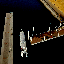

In [72]:
from IPython.display import Image
def make_gif(images, filename):
    ''' Method to save batch of images into a gif '''
    x = images.permute(0,2,3,1)
    x = x.numpy()
    x = img_as_ubyte(x)
    frames = []
    for i in range(32):
        frames += [x[i]]
    imageio.mimsave(filename, frames, duration=0.1)

make_gif(video_list[0].squeeze(), 'example.gif')
Image('example.gif', width=400, height=400)

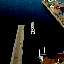

In [73]:
make_gif(video_list[1].squeeze(), 'example2.gif')
Image('example2.gif', width=400, height=400)

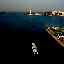

In [74]:
make_gif(video_list[2].squeeze(), 'example3.gif')
Image('example3.gif', width=400, height=400)

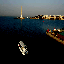

In [75]:
make_gif(video_list[3].squeeze(), 'example4.gif')
Image('example4.gif', width=400, height=400)

In [ ]:
make_gif(video_list[4].squeeze(), 'example.gif')
Image('example.gif', width=400, height=400)